# Multimodal Dataset Overview

## Financial dataset part

The source dataset for this dataset was 'ECL' dataset describe in https://arxiv.org/abs/2401.12652.
The companies in 'ECL' dataset were matched with companies in morningstar service and scrapped from it. Unfortunately, less than half of the companies were matched.

The dataset consists of 17 variables for each object in 5 years period.
Dataset was extended with synthetically generated data for positive class.

ECL github: https://github.com/henriarnoUG/ECL/tree/main

### Overview

In [111]:
import pandas as pd
import numpy as np

In [37]:
financial_dataset = pd.read_csv('bankrupt_companies-17_variables-5_years_per_object-balanced-split-matched_with_textual_data-shuffled.csv')
print(financial_dataset.shape)
financial_dataset.head()

(30580, 22)


,cik,label,subset,ticker,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,138291101,True,test,NaN,NaN,216.0,143.0,-164.0,-21.0,111.0,...,-348.0,-1548.0,327.0,1345.0,247.0,130.0,1.0,1719.0,277.0,75.0
1,138291101,True,test,NaN,NaN,202.0,134.0,-97.0,37.0,98.0,...,-317.0,-1588.0,301.0,1351.0,258.0,145.0,1.0,1696.0,193.0,80.0
2,138291101,True,test,NaN,NaN,203.0,116.0,-102.0,14.0,122.0,...,-104.0,-1692.0,325.0,1392.0,388.0,169.0,3.0,1656.0,231.0,88.0
3,138291101,True,test,NaN,NaN,259.0,113.0,-66.0,47.0,191.0,...,-97.0,-1789.0,451.0,1465.0,330.0,160.0,3.0,1812.0,253.0,115.0
4,138291101,True,test,NaN,NaN,299.0,118.0,-132.0,-14.0,173.0,...,-193.0,-1984.0,472.0,1200.0,217.0,126.0,2.0,1726.0,291.0,86.0


Every object consist of 5 years of financial data.

In [14]:
financial_data_grouped = financial_dataset.groupby('cik').agg({'label': 'first', 'subset': 'first', 'ticker': 'first'})
print(financial_data_grouped.shape)

(6116, 3)


In [15]:
financial_data_grouped['label'].value_counts()

label
False    3300
True     2816
Name: count, dtype: int64

Before extending the dataset, the distribution of the labels was strongly imbalanced in ratio 49-1. Below cell represents the distribution of the labels before extending the dataset.

In [17]:
financial_data_grouped_original_dataset = financial_data_grouped[~financial_data_grouped['ticker'].isnull()]
financial_data_grouped_original_dataset['label'].value_counts(normalize=True)

label
False    0.97981
True     0.02019
Name: proportion, dtype: float64

Artificially generated samples hasn't got 'ticker' and 'Fiscal Period' columns filled. Also 'cik' column for artificial samples is created by concatenating original 'cik' and id (which was number from 0 to 10, because of 10 synthetic samples for each object). There are some inconsistencies in the dataset - not every original sample has 10 synthetic samples.  

To oversample the minority class, the financial part of dataset was extended using SMOTE algorithm.

In [9]:
financial_data_grouped['subset'].value_counts(normalize=True)

subset
train    0.799706
test     0.150262
val      0.050033
Name: proportion, dtype: float64

### Example usage

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [76]:
financial_dataset_preprocessed = financial_dataset.drop(['cik', 'ticker', 'Fiscal Period'], axis=1)
X = financial_dataset_preprocessed.drop('label', axis=1)
y = financial_dataset_preprocessed['label']

In [81]:
def get_train_val_test_split(X, y):
    X_train = X[X['subset'] == 'train']
    y_train = y[X['subset'] == 'train']
    
    X_val = X[X['subset'] == 'val']
    y_val = y[X['subset'] == 'val']
    
    X_test = X[X['subset'] == 'test']
    y_test = y[X['subset'] == 'test']
    
    X_train = X_train.drop('subset', axis=1)
    X_val = X_val.drop('subset', axis=1)
    X_test = X_test.drop('subset', axis=1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [82]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)
len(X_train), len(X_val), len(X_test)

(24455, 1530, 4595)

In [58]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [32]:
confusion_matrix(y_test, y_pred)

array([[2430,   50],
       [  37, 2078]], dtype=int64)

In [36]:
print(f'accuracy_score: {accuracy_score(y_test, y_pred)}')
print(f'f1_score: {f1_score(y_test, y_pred)}')

accuracy_score: 0.9810663764961916
f1_score: 0.9794956398774453


### Functions for (de)flattening the dataset

Function flattens 5 years (rows) to single row.

In [124]:
def flatten_financial_dataset(financial_dataset):
    object_length_in_rows = 5
    per_object_columns = list(financial_dataset.columns[:object_length_in_rows].values)
    
    value_columns = financial_dataset.columns[object_length_in_rows:]
    new_columns = per_object_columns + [f'{col}_{i+1}' for i in range(object_length_in_rows) for col in value_columns]
    
    dfs = []
    
    for name, group in financial_dataset.groupby('cik'):
        label = group['label'].iloc[0]
        subset = group['subset'].iloc[0]
        ticker = group['ticker'].iloc[0]
        fiscal_periods = ';'.join(group['Fiscal Period'].astype(str).values)
    
        values = group.drop(columns=per_object_columns).values.flatten()
        
        dfs.append([name, label, subset, ticker, fiscal_periods] + values.tolist())
    
    final_flatten_df = pd.DataFrame(dfs, columns=new_columns)
    final_flatten_df = final_flatten_df.reset_index(drop=True)
    return final_flatten_df

In [125]:
flatten_df = flatten_financial_dataset(financial_dataset)
print(flatten_df.shape)
flatten_df.head()

(6116, 90)


,cik,label,subset,ticker,Fiscal Period,Cost of Goods Sold_1,"Depreciation, Depletion and Amortization_1",EBIT_1,EBITDA_1,Gross Profit_1,...,Net Income_5,Retained Earnings_5,Revenue_5,Total Assets_5,Total Current Assets_5,Total Current Liabilities_5,Total Inventories_5,Total Liabilities_5,Total Operating Expense_5,Total Receivables_5
0,1800,False,train,ABT,Dec 2016;Dec 2017;Dec 2018;Dec 2019;Dec 2020,9094.0,1353.0,1844.0,3197.0,11759.0,...,4495.0,27627.0,34608.0,72548.0,20441.0,11907.0,5012.0,39545.0,14248.0,8281.0
1,2034,True,train,NaN,nan;nan;nan;nan;nan,391.0,12.0,10.0,23.0,190.0,...,-16.0,-60.0,734.0,309.0,165.0,84.0,112.0,155.0,281.0,44.0
2,2488,False,train,AMD,Dec 2016;Dec 2017;Dec 2018;Dec 2019;Dec 2020,3316.0,133.0,-293.0,-160.0,1003.0,...,2490.0,-4605.0,9763.0,8962.0,6143.0,2417.0,1399.0,3125.0,2978.0,2076.0
3,2491,False,train,BYI,Jun 2010;Jun 2011;Jun 2012;Jun 2013;Jun 2014,274.0,75.0,155.0,230.0,484.0,...,99.0,745.0,1215.0,2519.0,593.0,252.0,82.0,2312.0,537.0,314.0
4,2852,True,train,NaN,nan;nan;nan;nan;nan,87.0,36.0,38.0,74.0,200.0,...,-79.0,-288.0,292.0,427.0,49.0,569.0,5.0,590.0,169.0,14.0


In [120]:
flatten_financial_dataset_preprocessed = flatten_df.drop(['cik', 'ticker', 'Fiscal Period'], axis=1)
X = flatten_financial_dataset_preprocessed.drop('label', axis=1)
y = flatten_financial_dataset_preprocessed['label']

X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(X, y)
len(X_train), len(X_val), len(X_test)

(4891, 306, 919)

In [121]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [122]:
confusion_matrix(y_test, y_pred)

array([[490,   6],
       [  1, 422]], dtype=int64)

In [123]:
print(f'accuracy_score: {accuracy_score(y_test, y_pred)}')
print(f'f1_score: {f1_score(y_test, y_pred)}')

accuracy_score: 0.9923830250272034
f1_score: 0.9917743830787309


Flattening the dataset slightly improves the results by ~1%.

### De-flattening the dataset

In [88]:
flatten_df.head()

,cik,label,subset,Cost of Goods Sold_1,"Depreciation, Depletion and Amortization_1",EBIT_1,EBITDA_1,Gross Profit_1,Long-Term Debt_1,Market Cap_1,...,Net Income_5,Retained Earnings_5,Revenue_5,Total Assets_5,Total Current Assets_5,Total Current Liabilities_5,Total Inventories_5,Total Liabilities_5,Total Operating Expense_5,Total Receivables_5
0,1800,False,train,9094.0,1353.0,1844.0,3197.0,11759.0,20681.0,56573.0,...,4495.0,27627.0,34608.0,72548.0,20441.0,11907.0,5012.0,39545.0,14248.0,8281.0
1,2034,True,train,391.0,12.0,10.0,23.0,190.0,16.0,0.0,...,-16.0,-60.0,734.0,309.0,165.0,84.0,112.0,155.0,281.0,44.0
2,2488,False,train,3316.0,133.0,-293.0,-160.0,1003.0,1435.0,10603.0,...,2490.0,-4605.0,9763.0,8962.0,6143.0,2417.0,1399.0,3125.0,2978.0,2076.0
3,2491,False,train,274.0,75.0,155.0,230.0,484.0,500.0,1806.0,...,99.0,745.0,1215.0,2519.0,593.0,252.0,82.0,2312.0,537.0,314.0
4,2852,True,train,87.0,36.0,38.0,74.0,200.0,355.0,17.0,...,-79.0,-288.0,292.0,427.0,49.0,569.0,5.0,590.0,169.0,14.0


In [147]:
def deflatten_financial_dataset(flatten_df):
    object_length_in_rows = 5
    info_columns_count = 5

    values_columns = flatten_df.columns[info_columns_count:]
    unique_values_columns = sorted(set(col.split('_')[0] for col in values_columns))
    
    new_columns = flatten_df.columns[:info_columns_count].tolist() + unique_values_columns

    deflattened_rows = []

    for _, row in flatten_df.iterrows():
        first_columns = row.values[:info_columns_count]
        fiscal_periods = row.values[4].split(';')
        
        reshaped_values = np.array(row.values[info_columns_count:]).reshape(object_length_in_rows, -1)
        
        for i in range(object_length_in_rows):
            new_row = np.concatenate([first_columns[:4], [fiscal_periods[i]], reshaped_values[i]])
            deflattened_rows.append(new_row)

    deflatten_df = pd.DataFrame(deflattened_rows, columns=new_columns)
    
    return deflatten_df.reset_index(drop=True)

In [148]:
deflatten_df = deflatten_financial_dataset(flatten_df)
deflatten_df.head()

,cik,label,subset,ticker,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,1800,False,train,ABT,Dec 2016,9094.0,1353.0,1844.0,3197.0,11759.0,...,1400.0,25565.0,20853.0,52666.0,26776.0,6660.0,2434.0,31949.0,8733.0,5054.0
1,1800,False,train,ABT,Dec 2017,12409.0,3021.0,3135.0,6156.0,14981.0,...,477.0,23978.0,27390.0,76250.0,20147.0,8912.0,3601.0,45152.0,13417.0,6916.0
2,1800,False,train,ABT,Dec 2018,12706.0,3278.0,3699.0,6977.0,17872.0,...,2368.0,24560.0,30578.0,67173.0,14632.0,9012.0,3796.0,36451.0,14222.0,6750.0
3,1800,False,train,ABT,Dec 2019,13231.0,3014.0,4747.0,7761.0,18673.0,...,3687.0,25847.0,31904.0,67887.0,15667.0,10863.0,4316.0,36586.0,14141.0,7211.0
4,1800,False,train,ABT,Dec 2020,15003.0,3327.0,5514.0,8841.0,19605.0,...,4495.0,27627.0,34608.0,72548.0,20441.0,11907.0,5012.0,39545.0,14248.0,8281.0


## Textual data

Textual data was being prepared after the financial part. For companies that were matched with morningstar, the textual data was accessible through: https://cloud.ilabt.imec.be/index.php/s/yrQneXG74bNYxLp, as the authors of the 'ECL' dataset provided the textual data - financial reports scrapped from edgar database.

The textual data was intended to be used be lightweight models like BERT. Furthermore, the crucial MD&A section form financial report has 6,810 words on average.
That is why it was necessary to shorten the text, in this case to 512 tokens.

Two models gemini-1.0-pro and gemini-1.5-pro-latest utilised through api were prompted with following text:
```
"You are a financial analyst, specialized in assessing companies' financial health and communicating with clients.
I have the management discussion and analysis from a company's 10k report, and I would like to know the elements that could indicate its financial health.
Provide a concise summary of the most important information from the investor perspective from the included text,
focusing on information about financial performance (e.g., revenue, profitability, liquidity and capital resources),
risks (industry Trends, competition, market fluctuations), or future outlook (e.g., growth strategies, acquisitions).
Do not split to paragraphs, give just list of sentence that make a summary out of the text.
Text: {text_for_prompt}, where text is a management's discussion and analysis section from a 10-K report,
with a maximum length of around 15000 words. Try to generate answer between 256 and 512 tokens length."
```

Created dataset is matched with above financial dataset and is corresponding to the same companies.
Positive class was oversampled through process of generation synonymous texts leveraging "https://api.ai21.com/studio/v1/paraphrase" endpoint. Also for almost every original summary, there is a copy of it made through another call to gemini models. As a result, the dataset is almost balanced.

### Overview

In [157]:
textual_dataset = pd.read_csv('textual_data-matched_and_aligned_with_fin_data-split.csv')
print(textual_dataset.shape)
textual_dataset.head()

(6116, 4)


,cik,label,subset,text
0,138291101,True,test,"As a biopharmaceutical company, Contrave is focused solely on the commercialization of its weight management drug. The company generated $33.7 million in revenue in 2016, up from $24.5 million in 2015. Contrave's first US net sales totaled $17.3 million in 2016. Future sales are difficult to predict at this stage in the company's commercialization process. Due to costs associated with establishing sales and marketing capabilities, selling, general, and administrative expenses decreased slightly. Unprofitable, the company reports a net loss and expects to continue incurring losses for several years. Contrave's success is essential to the company's profitability, as it depends on revenue to cover costs. To support operations, the company may issue equity, debt, or royalty-based agreements, all of which could dilution existing shareholders significantly. In order for Contrave to be successfully commercialized, needed regulatory approvals must be obtained, as well as adequate funding must be secured."
1,1324245,False,train,"Solera is a global provider of software and services for the automobile claims processing industry, serving over 165,000 customers in 70 countries. The company operates in two segments: EMEA and Americas, with the US and UK being the only countries representing more than 10% of total revenues in fiscal year 2014. Revenues are generated from sales of software and services under negotiated contracts or pricing agreements, with the core offering being estimating and workflow software. The company has a high customer retention rate due to customer integration and long-standing relationships. Revenue increased by 17.8% in fiscal year 2014, driven by the acquisition of SRS and organic growth in both segments, particularly in re-underwriting services and transaction-based revenues. Operating expenses and systems development and programming costs also increased due to acquisitions and investments in product development. The company actively pursues acquisitions as part of its growth strategy and recently acquired the Insurance and Services Division of Pittsburgh Glass Works. Solera believes its existing cash on hand and cash flow from operations are sufficient to fund working capital, debt service, acquisitions, and strategic investments for at least the next twelve months. The company is exposed to foreign currency fluctuations, primarily the Euro, and mitigates this risk through cross-currency swaps. Factors influencing business volume and revenue include the number of insurance claims, new and used vehicle sales, damaged vehicle repair costs, automobile usage, seasonality, and vehicle insurance penetration rates."
2,1178670,False,train,"The company is a commercial-stage biopharmaceutical company focusing on RNAi therapeutics. They have two approved products, ONPATTRO and GIVLAARI, and six late-stage investigational programs. The company has incurred significant losses since inception and expects losses to continue due to research and development costs. Revenue comes from product sales and collaborations with Regeneron, Sanofi Genzyme, and MDCO. Critical accounting policies include revenue recognition for product sales and collaborations, inventory capitalization, income tax accounting, stock-based compensation, and research and development accruals. Net product revenue increased in 2019 due to ONPATTRO sales and the launch of GIVLAARI. Collaboration revenue decreased in 2019 but is expected to increase in 2020 due to reimbursable activities and milestones. Operating expenses, including cost of goods sold, research and development, and selling, general and administrative expenses, increased in 2019 due to growth and commercialization activities. The company expects these expenses to continue increasing in 2020. As of December 31, 2019, the company had $1.54 billion in cash, cash equivalents, and marketable securities. They believe this is sufficient to fund operations for

In [152]:
textual_dataset['label'].value_counts()

label
False    3300
True     2816
Name: count, dtype: int64

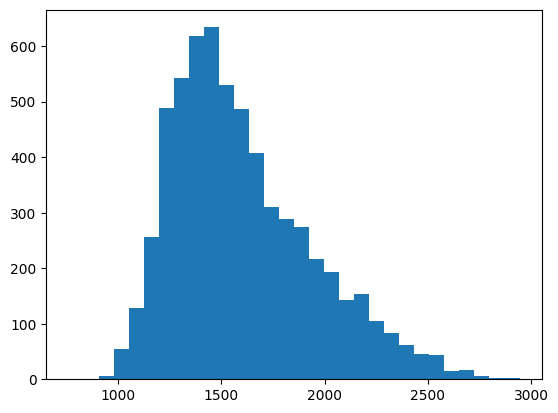

In [156]:
import matplotlib.pyplot as plt

text_lengths = [len(text) for text in textual_dataset['text'].values]
plt.hist(text_lengths, bins=30)
plt.show()

### Example usage

In [161]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import string

In [162]:
def preprocess_text(text):
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))
  return text

In [163]:
X = textual_dataset['text'].apply(preprocess_text)
y = textual_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [164]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [165]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_features, y_train)

y_pred = model.predict(X_test_features)

In [166]:
confusion_matrix(y_test, y_pred)

array([[640,  20],
       [ 35, 529]], dtype=int64)

In [167]:
print(f'accuracy_score: {accuracy_score(y_test, y_pred)}')
print(f'f1_score: {f1_score(y_test, y_pred)}')

accuracy_score: 0.9550653594771242
f1_score: 0.9505840071877808


In [169]:
new_texts = [
    "The company is experiencing steady revenue growth and profitability.",
    "The company is facing a class-action lawsuit and a potential product recall.",
    "The company is struggling to meet its financial obligations and may be at risk of bankruptcy."
]

for text in new_texts:
    new_text_features = vectorizer.transform([preprocess_text(text)])
    prediction = model.predict(new_text_features)[0]
    
    if prediction:
        print(f"Text: {text}\nPredicted: Bankruptcy")
    else:
        print(f"Text: {text}\nPredicted: Not Bankruptcy")

Text: The company is experiencing steady revenue growth and profitability.
Predicted: Not Bankruptcy
Text: The company is facing a class-action lawsuit and a potential product recall.
Predicted: Not Bankruptcy
Text: The company is struggling to meet its financial obligations and may be at risk of bankruptcy.
Predicted: Bankruptcy
